In [1]:
import warnings
warnings.filterwarnings('ignore')

import time
import os
from datetime import date

print(time.ctime())
path = os.path.abspath('')
print(path)
today = date.today().strftime('%d.%m.%Y')

Fri Jul  7 09:50:05 2023
/Users/khatran/Library/CloudStorage/OneDrive-TrườngĐạihọcPhenikaa/Quantum Computing/GitHub/GRAPE/GRAPE-for-qubit/experiments/x01_gate_lagos


In [2]:
from qiskit.tools.jupyter import *
from qiskit import pulse
from qiskit.circuit import Parameter, QuantumCircuit, Gate
from qiskit import schedule
from qiskit.tools.monitor import job_monitor
from qiskit_ibm_provider import IBMProvider

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import h5py

%matplotlib inline


In [3]:
provider = IBMProvider(token='abdde3a6d371faea730887657ff05f9d69f5d3592e57f8bb247bd591a25d7a0e87e6e6cc01494bfd9e6e69c27262a55ecc8eaa64a4fd9bc55cdbdad9f209ead4')

for backend in provider.backends():
    print(f'{backend.name}: {backend.status().pending_jobs}')


ibm_nairobi: 5277
ibm_lagos: 127
ibmq_quito: 8
ibmq_lima: 10
simulator_mps: 0
simulator_statevector: 0
ibmq_manila: 14
ibmq_jakarta: 108
ibmq_qasm_simulator: 0
ibmq_belem: 35
simulator_extended_stabilizer: 0
simulator_stabilizer: 0
ibm_perth: 95


In [4]:
backend = provider.get_backend('ibm_lagos')

In [5]:
print(backend.dt)

2.2222222222222221e-10


In [6]:
config = backend.configuration()

In [7]:
dt = config.dt

In [72]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibm_lagos')

ibmqfactory.load_account:WARNING:2023-07-08 16:05:51,709: Credentials are already in use. The existing account in the session will be replaced.


In [144]:
result = []

with h5py.File('/Users/khatran/Library/CloudStorage/OneDrive-TrườngĐạihọcPhenikaa/Quantum Computing/GitHub/GRAPE/GRAPE-for-qubit/output/x01_π/00021_x01_lagos.h5', 'r') as hf:
    data = hf.get('uks')
    result = data[...]

print(result.shape)

(5, 1, 1, 128)


In [145]:
data = result[4][0][0]
print(data.shape)

(128,)


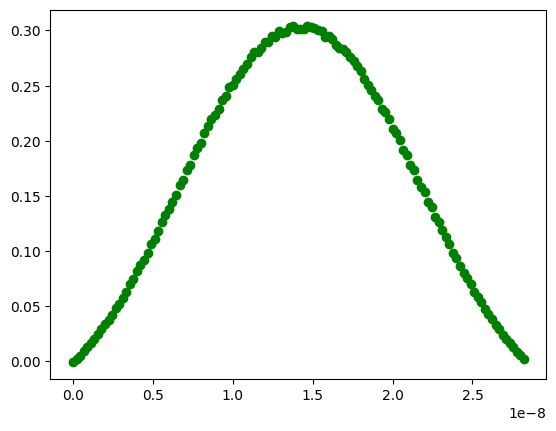

In [146]:
N = len(data)
T = dt * N
ops_max_amp = [2 * np.pi * 0.073036776]
Hnames = 'x'
plt.scatter(np.array([dt * ii for ii in range(len(data))]), np.array(data), color='green', marker='o', label='u' + Hnames + '0')

In [11]:
constraints = config.timing_constraints
acquire_alignment = constraints['acquire_alignment']
granularity = constraints['granularity']
pulse_alignment = constraints['pulse_alignment']

In [12]:
lcm = np.lcm(acquire_alignment, pulse_alignment)
defaults = backend.defaults()

In [13]:
GHz = 1.0e9
MHz = 1.0e6
us = 1.0e-6
ns = 1.0e-9
qubit = 0
scale_factor = 1e-7

In [14]:
freq_Hz = defaults.qubit_freq_est[qubit]
print(f"Qubit {qubit} has an estimated frequency of {freq_Hz / GHz} GHz.")

Qubit 0 has an estimated frequency of 5.23535192562653 GHz.


In [15]:
freq_span_Hz = 40 * MHz
freq_step_Hz = 1 * MHz

freq_min = freq_Hz - freq_span_Hz / 2
freq_max = freq_Hz + freq_span_Hz / 2
freqs_GHz = np.arange(freq_min / GHz, freq_max / GHz, freq_step_Hz / GHz)
print(f"The sweep will go from {freq_min / GHz} GHz to {freq_max / GHz} GHz in steps of {freq_step_Hz / GHz} GHz.")

The sweep will go from 5.215351925626529 GHz to 5.255351925626529 GHz in steps of 0.001 GHz.


In [16]:
def get_closest_multiple_of(value, base_number):
    return int(value + base_number/2) - (int(value + base_number/2) % base_number)

# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return get_closest_multiple_of(num, granularity)

# Convert seconds to dt
def get_dt_from(sec):
    return get_closest_multiple_of(sec/dt, lcm)

In [17]:
drive_sigma_sec = 0.015 * us
drive_duration_sec = drive_sigma_sec * 8
drive_amp = 0.05

In [18]:
from qiskit.pulse import Waveform

In [147]:
with pulse.build(backend, name='pi_01 pulse') as pi01_pulse:
    pulse_amp = Waveform(data, name='pi_01')
    dur = len(data)
    d0 = pulse.DriveChannel(0)
    pulse.set_frequency(freq_Hz, d0)
    pulse.play(pulse_amp, d0)

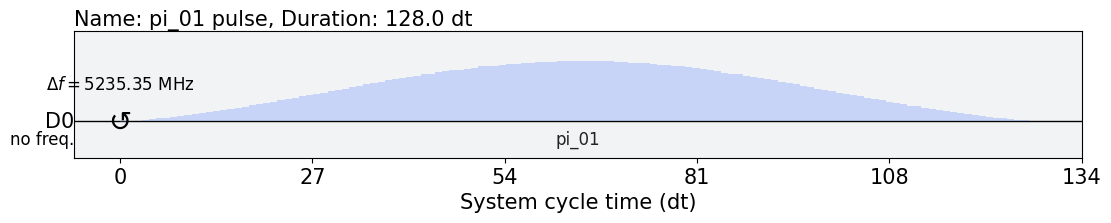

In [148]:
pi01_pulse.draw()

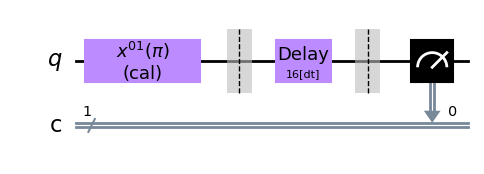

In [149]:
x01_π = Gate('$x^{01}(π)$', 1, [])

qc = QuantumCircuit(1, 1)
qc.append(x01_π, [0])
qc.barrier()
qc.delay(16)
qc.barrier()
qc.measure(0, 0)
qc.add_calibration(x01_π, (0,), pi01_pulse, [])

qc.draw(output='mpl')

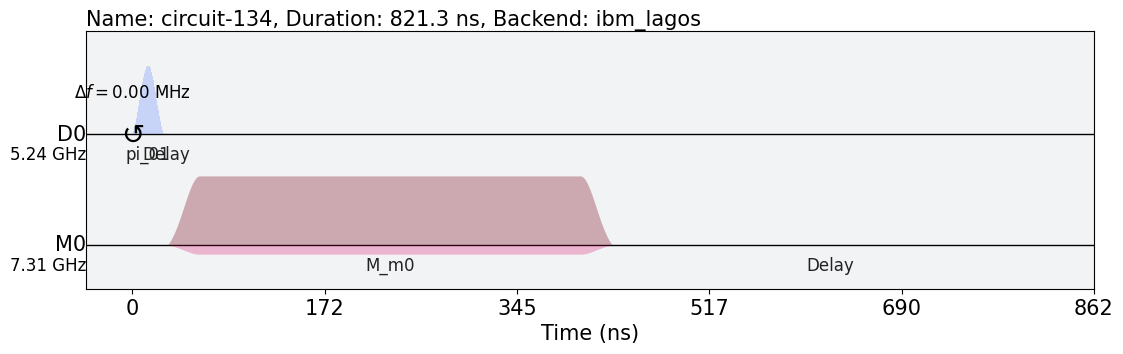

In [150]:
exc_sched = schedule(qc, backend)
exc_sched.draw(backend=backend)

In [151]:
q0 = QuantumCircuit(1,1)
q0.measure(0,0)

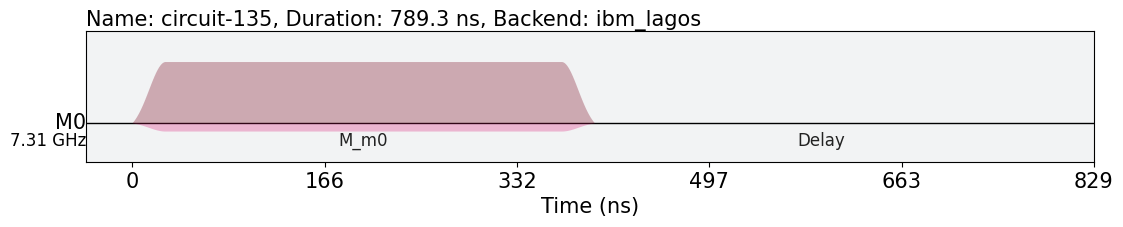

In [152]:
g0_schedule = schedule(q0, backend)
g0_schedule.draw(backend=backend)

In [153]:
num_shots = 2048

job = backend.run([q0, qc],
                  meas_level=1,
                  meas_return='single',
                  shots=num_shots)

In [154]:
print(job.job_id()) # N = 128

cikj0nllipn668ai07eg


In [143]:
print(job.job_id()) # N = 112

cikj0ed5ear1k1nao34g


In [131]:
print(job.job_id()) # N = 96

cikj014b0ilvhai5kacg


In [120]:
print(job.job_id()) # N = 80

cikivn4b0ilvhai5k35g


In [42]:
result = job.result(timeout=120)

In [43]:
scale_factor = 1e-7
s0_results = result.get_memory(0)[:,qubit] * scale_factor
s1_results = result.get_memory(1)[:,qubit] * scale_factor

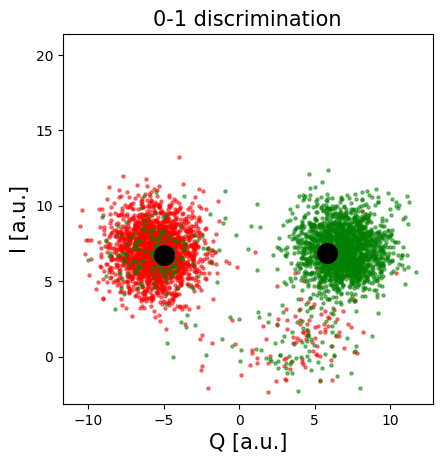

In [44]:
plt.figure()
plt.scatter(np.real(s0_results), np.imag(s0_results), s=5, cmap='viridis', c='red', alpha=0.5, label='state_0')
plt.scatter(np.real(s1_results), np.imag(s1_results), s=5, cmap='viridis', c='green', alpha=0.5, label='state_1')
plt.axis('square')

mean_gnd = np.mean(s0_results)
mean_exc = np.mean(s1_results)

plt.scatter(np.real(mean_gnd), np.imag(mean_gnd), s=200, cmap='viridis', c='black',alpha=1.0, label='state_0_mean')
plt.scatter(np.real(mean_exc), np.imag(mean_exc), s=200, cmap='viridis', c='black',alpha=1.0, label='state_1_mean')
plt.ylabel('I [a.u.]', fontsize=15)
plt.xlabel('Q [a.u.]', fontsize=15)
plt.title("0-1 discrimination", fontsize=15)
plt.show()

In [45]:
def reshape_complex_vec(vec):
    length = len(vec)
    vec_reshaped = np.zeros((length, 2))
    for i in range(len(vec)):
        vec_reshaped[i]=[np.real(vec[i]), np.imag(vec[i])]
    return vec_reshaped

In [46]:
def get_job_data(job, average):
    job_results = job.result(timeout = 120) # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average: # get avg data
            result_data.append(np.real(job_results.get_memory(i)[qubit] * scale_factor))
        else: # get single data
            result_data.append(job_results.get_memory(i)[:, qubit] * scale_factor)
    return result_data

In [51]:
IQ_01_data = get_job_data(job, average=False)
zero_data = IQ_01_data[0]
one_data = IQ_01_data[1]

In [52]:
zero_data_reshaped = reshape_complex_vec(zero_data)
one_data_reshaped = reshape_complex_vec(one_data)  

IQ_01_data = np.concatenate((zero_data_reshaped, one_data_reshaped))
print(IQ_01_data.shape)

(4096, 2)


In [53]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

In [54]:

state_01 = np.zeros(num_shots) 
state_01 = np.concatenate((state_01, np.ones(num_shots)))
print(len(state_01))

IQ_01_train, IQ_01_test, state_01_train, state_01_test = train_test_split(IQ_01_data, state_01, test_size=0.5)

4096


In [55]:
LDA_01 = LinearDiscriminantAnalysis()
LDA_01.fit(IQ_01_train, state_01_train)

LinearDiscriminantAnalysis()

In [56]:
print(LDA_01.predict([ [0, 0], [-10, 0], [-15, -5] ]))

[0. 0. 0.]


In [57]:
score_01 = LDA_01.score(IQ_01_test, state_01_test)
print(score_01)

0.931640625


In [58]:
def separatrixPlot(lda, x_min, x_max, y_min, y_max, shots):
    nx, ny = shots, shots

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)

    plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='black')

In [59]:
def IQ_01_plot(x_min, x_max, y_min, y_max):
    plt.scatter(np.real(zero_data), np.imag(zero_data), s=5, cmap='viridis', c='red', alpha=0.5, label=r'$|0\rangle$')
    plt.scatter(np.real(one_data), np.imag(one_data), s=5, cmap='viridis', c='green', alpha=0.5, label=r'$|1\rangle$')
    mean_zero = np.mean(zero_data)
    mean_one = np.mean(one_data)
    plt.scatter(np.real(mean_zero), np.imag(mean_zero), s=200, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_one), np.imag(mean_one), s=200, cmap='viridis', c='black',alpha=1.0)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min,y_max)
    plt.legend()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1 discrimination", fontsize=15)

In [62]:
x_min = -10
x_max = 10
y_min = -20
y_max = 20

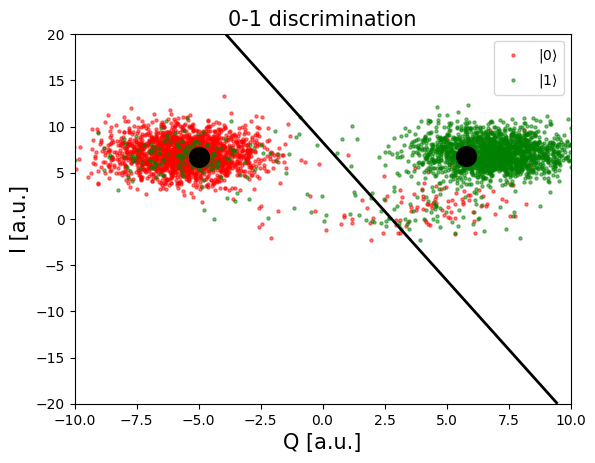

In [63]:
IQ_01_plot(x_min, x_max, y_min, y_max)
separatrixPlot(LDA_01, x_min, x_max, y_min, y_max, num_shots)